In [1]:
import re

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from wordcloud import WordCloud

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# **DATA LOADING** 📁

In [3]:
data = pd.read_csv('dataset/Corona_NLP_train.csv', encoding='latin-1')
test_data = pd.read_csv('dataset/Corona_NLP_test.csv', encoding='latin-1')

In [4]:
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [6]:
data.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [7]:
data.duplicated().sum()

0

# **DATA PREPRCESSING** 🔨

In [8]:
data['Location'].fillna('Unkown', inplace=True)

In [9]:
data.isnull().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

In [10]:
# Const values that are going to be used many times

TARGET = 'Sentiment'
TARGET_CODE = 'SentimentCode'
TEXT = 'OriginalTweet'
PROCESSED = 'ProcessedText'

In [35]:
data[TARGET] = data[TARGET].replace(['Extremely Positive', 'Extremely Negative'], ['Positive', 'Negative'])
test_data[TARGET] = test_data[TARGET].replace(['Extremely Positive', 'Extremely Negative'], ['Positive', 'Negative'])

In [48]:
data[TARGET_CODE] = pd.Categorical(data[TARGET]).codes
test_data[TARGET_CODE] = pd.Categorical(test_data[TARGET]).codes

In [13]:
class Preprocessor:
    def __init__(self, stopwords=stopwords):
        self.stoplist = set(stopwords.words("english"))
        self.lemmatizer = WordNetLemmatizer()
    
    @staticmethod
    def lower_texts(texts):
        print('Lowering...')
        return [text.lower() for text in tqdm(texts)]

    @staticmethod
    def remove_urls(texts):
        print('Removing URLs...')
        pattern = re.compile("(\w+\.com ?/ ?.+)|(http\S+)")
        return [re.sub(pattern, '', text) for text in tqdm(texts)]
    
    @staticmethod
    def remove_double_space(texts):
        print('Removing double space...')
        pattern = re.compile(' +')
        return [re.sub(pattern, ' ', text) for text in tqdm(texts)]
    
    @staticmethod
    def remove_punctuations(texts):
        print('Removing Punctuation...')
        pattern = re.compile('[^a-z ]')
        return [re.sub(pattern, ' ', text) for text in tqdm(texts)]
    
    @staticmethod
    def remove_html(texts):
        print('Removing HTML tags...')
        pattern = re.compile("<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>")
        return [re.sub(pattern, '', text) for text in tqdm(texts)]
    
    @staticmethod
    def remove_mentions(texts):
        print('Removing mentions...')
        pattern = re.compile('@[\w]+')
        return [re.sub(pattern, '', text) for text in tqdm(texts)]
    
    @staticmethod
    def remove_hashtags(texts):
        print('Removing hashtags...')
        pattern = re.compile('#\w+')
        return [re.sub(pattern, '', text) for text in tqdm(texts)]
    
    @staticmethod
    def remove_numbers(texts):
        print('Removing numbers...')
        return [' '.join([w for w in text if not w.isdigit()]) for text in tqdm(texts)]
    
    def remove_stopwords(self, texts):
        print('Removing stopwords...')
        return [[w for w in text.split(' ') if w not in self.stoplist] for text in tqdm(texts)]

     
    def lemmatize(self, texts):
        print('Lemmatizing...')     
        return [self.lemmatizer.lemmatize(text) for text in tqdm(texts)]
        
    def transform(self, X):
        X = X.copy()
        X = X[~X.isnull()]                           # delete nans
        X = X[~X.duplicated()]                       # delete duplicates
        X = self.lower_texts(X)                      # lower texts
        X = self.remove_mentions(X)                  # remove mentions(@)
        X = self.remove_hashtags(X)                  # remove hashtags
        X = self.remove_urls(X)                      # remove urls
        X = self.remove_punctuations(X)              # remove punctuations
        X = self.remove_html(X)                      # remove html tags
        X = self.remove_double_space(X)              # remove double space
        X = self.remove_stopwords(X)                 # remove stopwords
        X = self.remove_numbers(X)                   # remove numbers                      
        X = self.lemmatize(X)                        # lemmatize
        
        return X

In [14]:
pr = Preprocessor()
data[PROCESSED] = pr.transform(data[TEXT])
test_data[PROCESSED] = pr.transform(test_data[TEXT])

Lowering...


100%|██████████| 41157/41157 [00:00<00:00, 1209824.16it/s]


Removing mentions...


100%|██████████| 41157/41157 [00:00<00:00, 601885.48it/s]


Removing hashtags...


100%|██████████| 41157/41157 [00:00<00:00, 429626.95it/s]


Removing URLs...


100%|██████████| 41157/41157 [00:00<00:00, 82883.79it/s]


Removing Punctuation...


100%|██████████| 41157/41157 [00:00<00:00, 230762.61it/s]


Removing HTML tags...


100%|██████████| 41157/41157 [00:00<00:00, 547005.12it/s]


Removing double space...


100%|██████████| 41157/41157 [00:00<00:00, 121685.65it/s]


Removing stopwords...


100%|██████████| 41157/41157 [00:00<00:00, 108497.31it/s]


Removing numbers...


100%|██████████| 41157/41157 [00:00<00:00, 340113.54it/s]


Lemmatizing...


100%|██████████| 41157/41157 [00:01<00:00, 25760.35it/s]


Lowering...


100%|██████████| 3798/3798 [00:00<00:00, 749539.67it/s]


Removing mentions...


100%|██████████| 3798/3798 [00:00<00:00, 632995.57it/s]


Removing hashtags...


100%|██████████| 3798/3798 [00:00<00:00, 275347.71it/s]


Removing URLs...


100%|██████████| 3798/3798 [00:00<00:00, 70909.52it/s]


Removing Punctuation...


100%|██████████| 3798/3798 [00:00<00:00, 169823.64it/s]


Removing HTML tags...


100%|██████████| 3798/3798 [00:00<00:00, 476331.87it/s]


Removing double space...


100%|██████████| 3798/3798 [00:00<00:00, 99316.48it/s]


Removing stopwords...


100%|██████████| 3798/3798 [00:00<00:00, 95699.62it/s]


Removing numbers...


100%|██████████| 3798/3798 [00:00<00:00, 295168.83it/s]


Lemmatizing...


100%|██████████| 3798/3798 [00:00<00:00, 236097.44it/s]


In [15]:
data[[TEXT, TARGET, PROCESSED]]

,OriginalTweet,Sentiment,ProcessedText
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...
3,My food stock is not the only one which is emp...,Positive,food stock one empty please panic enough food ...
4,"Me, ready to go at supermarket during the #COV...",Negative,ready go supermarket outbreak paranoid food st...
...,...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral,airline pilots offering stock supermarket shel...
41153,Response to complaint not provided citing COVI...,Negative,response complaint provided citing covid relat...
41154,You know itÂs getting tough when @KameronWild...,Positive,know getting tough rationing toilet paper mart...
41155,Is it wrong that the smell of hand sanitizer i...,Neutral,wrong smell hand sanitizer starting turn


In [16]:
# drop rows with empty ProcessedText 

indices = data[data[PROCESSED].str.strip()==''].index
data.drop(indices, inplace=True)

indices = test_data[test_data[PROCESSED].str.strip()==''].index
test_data.drop(indices, inplace=True)

# **EDA** 📊

In [17]:
sns.set_style('darkgrid')

In [18]:
def top_10_plot(text, regex, col_name, **kwargs):
    data[col_name] = data[TEXT].apply(lambda x:" ".join(re.findall(rf'{regex}', x)))
    temp = data[col_name].value_counts()[:][1:11]
    temp =temp.to_frame().reset_index().rename(columns={'index':col_name, col_name:'count'})
    return sns.barplot(
        x=col_name,
        y="count",
        data=temp,
        **kwargs
    ).set_title(f'TOP 10 {col_name}')

Text(0.5, 1.0, 'TOP 10 hashtags')

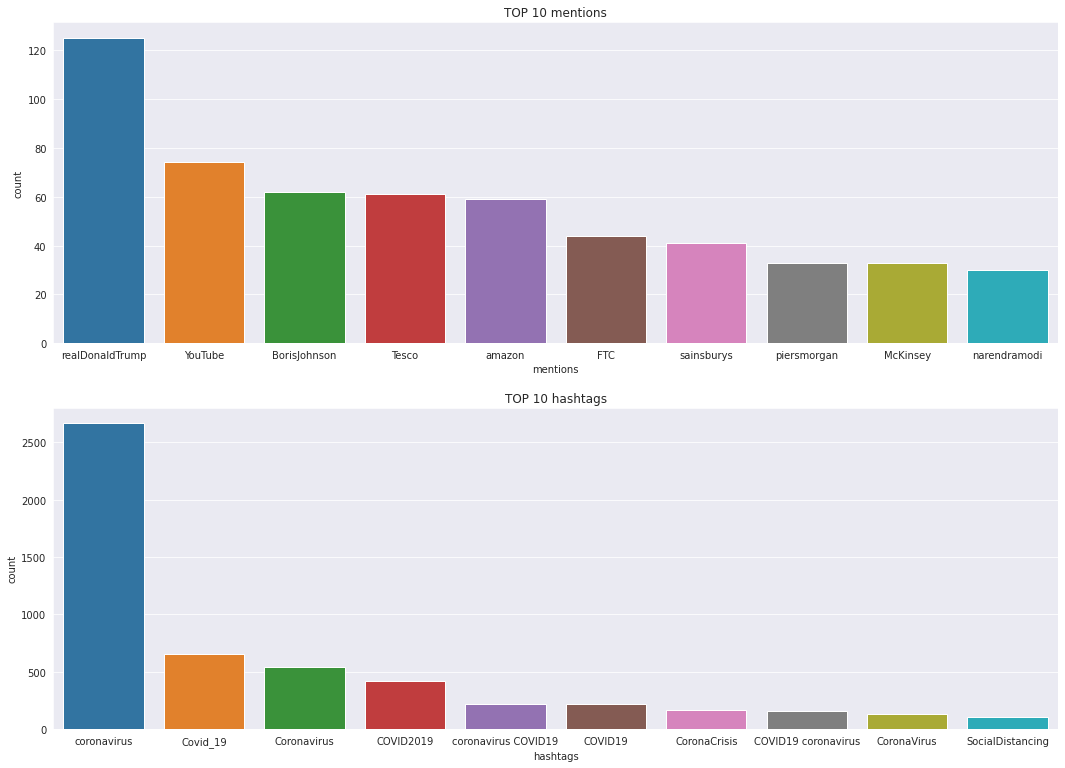

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,13))

top_10_plot(TEXT, '(?<=@)\w+', 'mentions', ax=axes[0]) # top10 mentions
top_10_plot(TEXT, '(?<=#)\w+', 'hashtags', ax=axes[1]) # top10 hashtags

In [20]:
# sentiments of tweets distribution table

label_distribution = data.groupby(TARGET).count()[TEXT].reset_index().sort_values(by=TEXT, ascending=False)
label_distribution.style.background_gradient(cmap='winter')

,Sentiment,OriginalTweet
2,Positive,18044
0,Negative,15397
1,Neutral,7664


In [21]:
# top10 locations of tweets distribution table

location_distribution = data.groupby('Location').count()[TEXT].reset_index().sort_values(by=TEXT, ascending=False)[:10]
location_distribution.style.background_gradient(cmap='autumn')

,Location,OriginalTweet
10474,Unkown,8574
5682,London,539
10440,United States,526
5757,"London, England",520
7082,"New York, NY",395
10779,"Washington, DC",373
10418,United Kingdom,337
5864,"Los Angeles, CA",281
4721,India,267
10268,UK,232


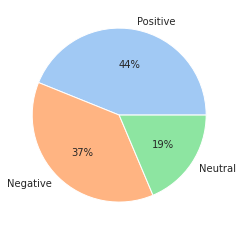

In [22]:
# pie chart for better understanding of each labels' portion

colors = sns.color_palette('pastel')
value_counts = data[TARGET].value_counts()
labels = label_distribution.Sentiment

# create pie chart
plt.pie(value_counts, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

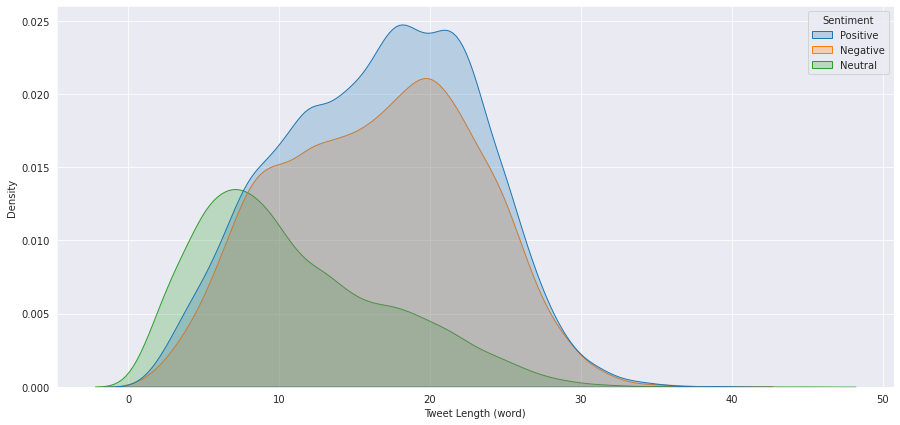

In [23]:
tweets_len = pd.DataFrame(
    {
        'Tweet Length (word)':[len(text.split()) for text in data[PROCESSED]],
        'Sentiment': data[TARGET]
    }
)
plt.figure(figsize=(15, 7))
sns.kdeplot(data=tweets_len, x='Tweet Length (word)', hue='Sentiment', fill=True)
plt.show()

In [24]:
word_counts = {label: [] for label in label_distribution.Sentiment}

for text, target in zip(data[PROCESSED], data[TARGET]):
    text = [word for word in text.split()]
    word_counts[target].extend(text)

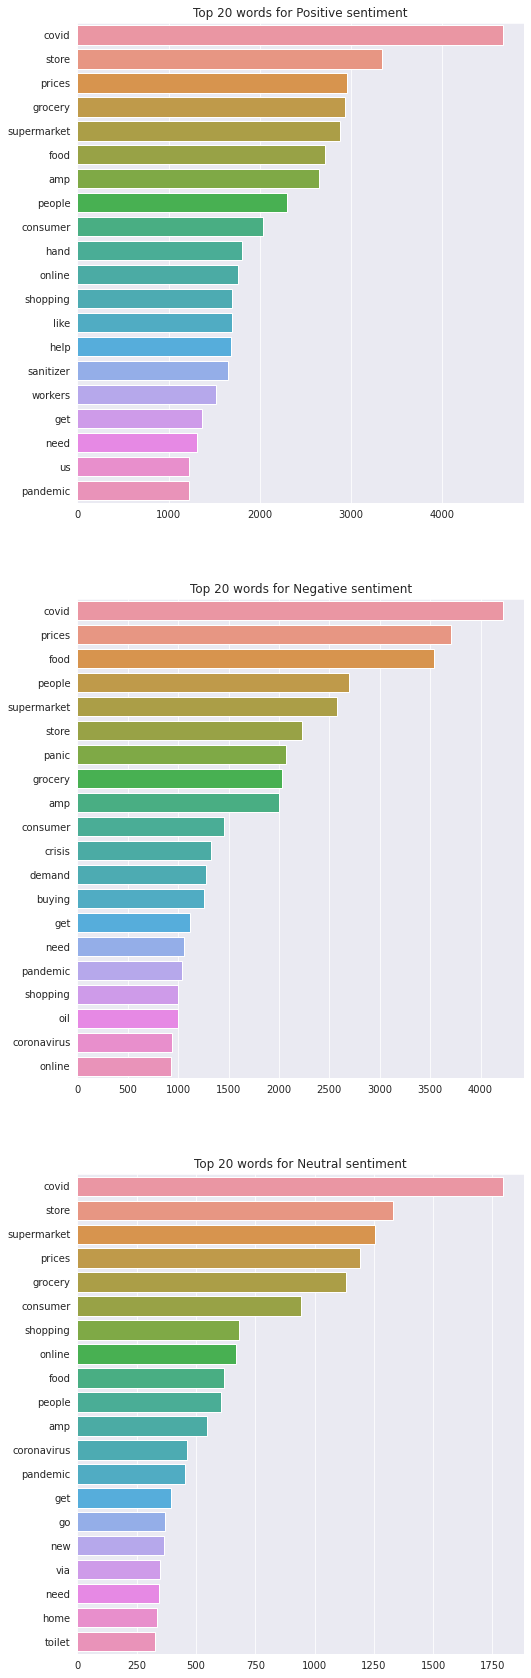

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(8, 30))

for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:20]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top 20 words for {target} sentiment')
plt.show()

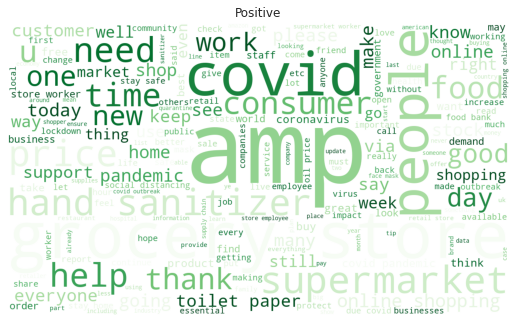

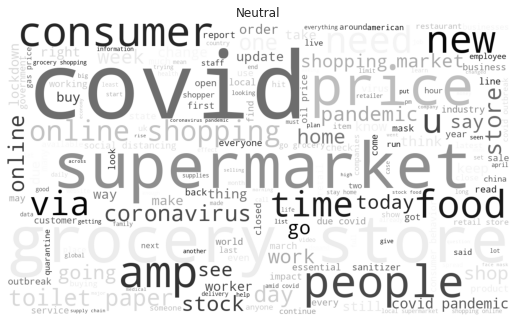

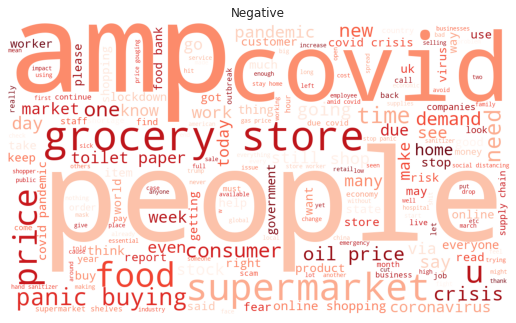

In [26]:
labels = ['Positive', 'Neutral', 'Negative']
colormaps = ['Greens', 'Greys', 'Reds']

for label, colormap in zip(labels, colormaps):
    text = " ".join(word for word in data.loc[data[TARGET] == label, PROCESSED])
    wordcloud = WordCloud(
        width=1200,
        height=700,
        background_color="white",
        colormap=colormap,
        min_font_size=10
    ).generate(text)
    plt.figure(figsize=(9, 7), facecolor=None)
    plt.title(label)
    plt.axis("off")
    plt.imshow(wordcloud)

# **DATA SPLIT**

In [28]:
# split data into train/validation 90:10

np.random.seed(112)
df_train, df_val = np.split(data.sample(frac=1, random_state=42), 
                                     [int(.9*len(data))])

print(f'Train Set Length: {len(df_train)}, Validation Set Length: {len(df_val)}')

Train Set Length: 36994, Validation Set Length: 4111


# **CUSTOM DATASET**

In [29]:
from transformers import BertTokenizer



class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
        self.labels = [label for label in df[TARGET_CODE]]
        self.texts = [self.tokenizer(text, 
                               padding='max_length', max_length=50, truncation=True,
                                return_tensors="pt") for text in df[PROCESSED]]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

# **MODEL**

In [30]:
from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self, class_num):
        super(BertClassifier, self).__init__()
        self.class_num = class_num
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.fc = nn.Sequential(
            nn.Linear(768, 256),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(128, self.class_num),
        )

    def forward(self, input_ids, mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=mask, return_dict=False)
        out = self.fc(pooled_output)

        return out

# **TRAINING**

In [64]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=32, num_workers=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=32, num_workers=2, shuffle=True)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader, 'Training...'):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_ids = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_ids, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in tqdm(val_dataloader, 'Validating...'):

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(f"Epoch {epoch_num + 1}/{EPOCHS}:")
            print(f"Train Loss: {total_loss_train / len(train_data): .3f}, Train Accuracy: {total_acc_train / len(train_data): .3f}")
            print(f"Validation Loss: {total_loss_val / len(val_data): .3f}, Validation Accuracy: {total_acc_val / len(val_data): .3f}")
            print('-'*40)

                  
EPOCHS = 5
LR = 2e-5
model = BertClassifier(3)

train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Validating...: 100%|██████████| 129/129 [00:11<00:00, 11.34it/s]


Epoch 1/5:
Train Loss:  0.017, Train Accuracy:  0.805
Validation Loss:  0.012, Validation Accuracy:  0.875
----------------------------------------


Validating...: 100%|██████████| 129/129 [00:11<00:00, 11.34it/s]


Epoch 2/5:
Train Loss:  0.009, Train Accuracy:  0.908
Validation Loss:  0.011, Validation Accuracy:  0.887
----------------------------------------


Validating...: 100%|██████████| 129/129 [00:11<00:00, 11.33it/s]


Epoch 3/5:
Train Loss:  0.006, Train Accuracy:  0.939
Validation Loss:  0.011, Validation Accuracy:  0.877
----------------------------------------


Validating...: 100%|██████████| 129/129 [00:11<00:00, 11.34it/s]


Epoch 4/5:
Train Loss:  0.005, Train Accuracy:  0.959
Validation Loss:  0.013, Validation Accuracy:  0.888
----------------------------------------


Validating...: 100%|██████████| 129/129 [00:11<00:00, 11.36it/s]


Epoch 5/5:
Train Loss:  0.003, Train Accuracy:  0.973
Validation Loss:  0.014, Validation Accuracy:  0.884
----------------------------------------


# **EVALUATION** ✅

In [65]:
y_true_list = []
y_pred_list = []


def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=32, num_workers=2, shuffle=True)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              _, predictions = torch.max(output, 1)
              acc = (predictions == test_label).sum().item()
              total_acc_test += acc

              y_true_list.append(test_label.cpu().numpy())
              y_pred_list.append(predictions.cpu().numpy())
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, test_data)

y_true_list = list(np.concatenate(y_true_list).flat)
y_pred_list = list(np.concatenate(y_pred_list).flat)

Test Accuracy:  0.866


# **CONFUSION MATRIX** 🏁

In [66]:
from sklearn.metrics import classification_report, confusion_matrix


print(confusion_matrix(y_true_list, y_pred_list))

[[1371   63  199]
 [  55  500   61]
 [ 111   21 1414]]


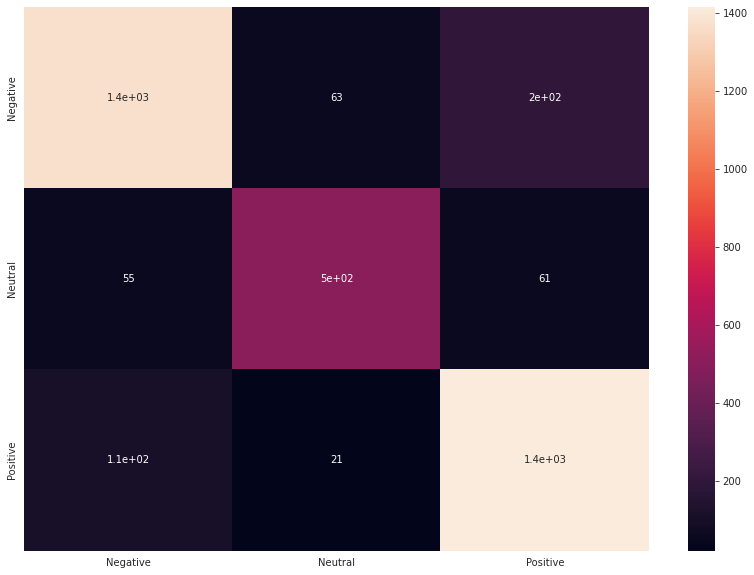

In [67]:
def plot_confusion_matrix(df, y_true_list, y_pred_list):
  index_to_label = {k:v for k, v in enumerate(pd.Categorical(df[TARGET]).categories)}
  confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=index_to_label, index=index_to_label)
  fig, ax = plt.subplots(figsize=(14,10))         
  return sns.heatmap(confusion_matrix_df, annot=True, ax=ax)


plot_confusion_matrix(test_data, y_true_list, y_pred_list)

# **TRY OUT YOUR TWEETS** 🙂

In [113]:
def test_single_sentence(text):
  categories = ['Negative', 'Neutral', 'Positive']
  tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
  bert_input = tokenizer(text, padding='max_length', max_length=50, 
                        truncation=True, return_tensors="pt")

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  mask = bert_input['attention_mask'].to(device)
  input_ids = bert_input['input_ids'].squeeze(1).to(device)
  output = model(input_ids, mask)
  prediction = torch.argmax(output, dim=1).item()
  return categories[prediction]


In [117]:
sample_texts = [
        "this cant be worse. people are dying.",
        "Good news is coming.",
        "Another boring day in quarantine...",
        "Second wave of #COVID19 in Flanders..back to more #homework again...",
        "OK I'm angry now. I cannot believe the stupidity there is out there about #COVID19.",
        "Thank GOD! Coronavirus: No deaths reported for 48 hours in Qatar.",
        "I lost my cousine because of CORONAVIRUS last week. can't believe it...",
        "Get the latest info and updates on #COVID19 on the Canada.ca",
        "I got vaccinated today. Hope this #COVID19 ends soon.",
        "supermarkets are running out of paper toilets. This is a shame for the gov!!!"
]

pre_processed_sample_texts = Preprocessor().transform(pd.Series(sample_texts))

Lowering...


100%|██████████| 10/10 [00:00<00:00, 79739.62it/s]


Removing mentions...


100%|██████████| 10/10 [00:00<00:00, 74631.74it/s]


Removing hashtags...


100%|██████████| 10/10 [00:00<00:00, 78840.30it/s]


Removing URLs...


100%|██████████| 10/10 [00:00<00:00, 48770.98it/s]


Removing Punctuation...


100%|██████████| 10/10 [00:00<00:00, 76121.67it/s]


Removing HTML tags...


100%|██████████| 10/10 [00:00<00:00, 75301.69it/s]


Removing double space...


100%|██████████| 10/10 [00:00<00:00, 61862.89it/s]


Removing stopwords...


100%|██████████| 10/10 [00:00<00:00, 62695.13it/s]


Removing numbers...


100%|██████████| 10/10 [00:00<00:00, 100102.72it/s]


Lemmatizing...


100%|██████████| 10/10 [00:00<00:00, 51025.60it/s]


In [118]:
for text, pr_text in zip(sample_texts, pre_processed_sample_texts):
  print(f'Text: {text}')
  print(f'Predicted Sentiment: {test_single_sentence(pr_text)}')
  print('-'*30)

Text: this cant be worse. people are dying.
Predicted Sentiment: Negative
------------------------------
Text: Good news is coming.
Predicted Sentiment: Positive
------------------------------
Text: Another boring day in quarantine...
Predicted Sentiment: Negative
------------------------------
Text: Second wave of #COVID19 in Flanders..back to more #homework again...
Predicted Sentiment: Neutral
------------------------------
Text: OK I'm angry now. I cannot believe the stupidity there is out there about #COVID19.
Predicted Sentiment: Negative
------------------------------
Text: Thank GOD! Coronavirus: No deaths reported for 48 hours in Qatar.
Predicted Sentiment: Positive
------------------------------
Text: I lost my cousine because of CORONAVIRUS last week. can't believe it...
Predicted Sentiment: Negative
------------------------------
Text: Get the latest info and updates on #COVID19 on the Canada.ca
Predicted Sentiment: Neutral
------------------------------
Text: I got vaccina